In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import (
    gamma, poisson, linregress, norm, skew, lognorm,
    truncpareto, poisson_binom
)
from scipy.integrate import cumulative_trapezoid, trapezoid
import math
import time
import random
import pickle as pkl
from cratersfd import *
import ash
import os, re
%matplotlib inline

plt.rcParams['font.family'] = 'Helvetica'

In [2]:
d_min = 0.01
area = 1.0
long_ds = np.loadtxt('../data/long_npf_synthetic.csv')
ds = long_ds[long_ds > d_min]
dmin = 0.03
mean_ratio_dict = {}

Runtime: 1.26763 seconds
Runtime: 1.26329 seconds
Runtime: 1.23809 seconds
Runtime: 1.21065 seconds
Runtime: 1.29422 seconds
Runtime: 1.27806 seconds
Runtime: 1.29177 seconds
Runtime: 1.30464 seconds
Runtime: 1.23813 seconds


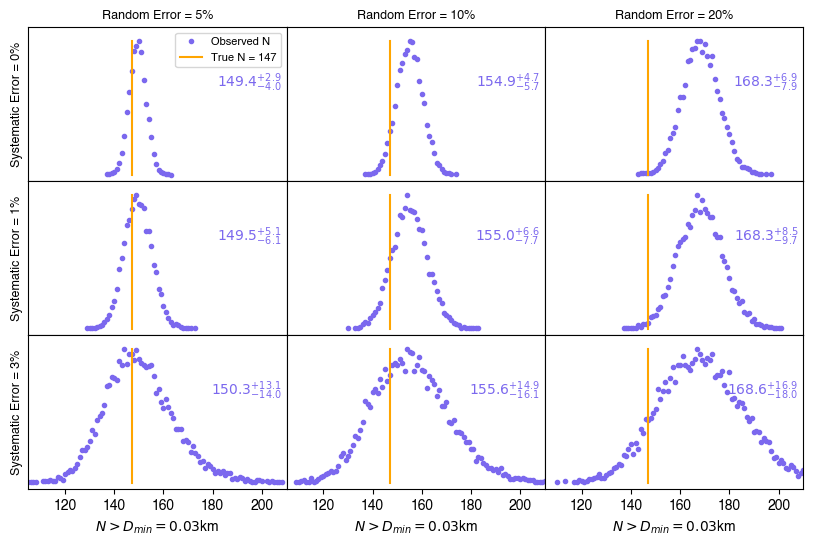

In [3]:
n_steps = 10000
d_randoms = [1.05, 1.1, 1.2]
d_systematics = [1, 1.01, 1.03]

raw_N = ds[ds > dmin].size

fig = plt.figure(figsize=(10, 6))

for i in range(0, 9):
    time0()
    ax = fig.add_subplot(3, 3, i + 1)
    d_random = d_randoms[i % 3]
    d_systematic = d_systematics[i // 3]
    n_samples = n_steps * ds.size
    random_samples = sample_factor_pdf(1, d_random, n_samples)
    random_matrix = np.array_split(random_samples, n_steps)
    systematic_vector = sample_factor_pdf(1, d_systematic, n_steps)
    error_ds = random_matrix * systematic_vector[:, np.newaxis] * ds
    sample_Ns = (error_ds > dmin).sum(axis=1)
    Ns, counts = np.unique(sample_Ns, return_counts=True)
    forward_pmf = DiscreteRandomVariable(Ns, counts)
    forward_pmf.plot(
        no_box=False, label='Observed N', show_label=True, 
        rounding_n=1, dn=0, label_x=208, label_y=0.6, 
        force_label_side='right'
    )
    plt.yticks([])
    plt.plot(
        [raw_N, raw_N], [0, 1], 
        label='True N = ' + str(raw_N), color='orange'
    )
    plt.xlim([105, 210])
    plt.ylim([-0.05, 1.1])
    if i == 0:
        plt.legend(fontsize=8, loc='upper right')
    plt.xlabel(rf'$N>D_{{min}}={dmin}$km')
    if i < 3:
        percent = str(round(100 * (d_random - 1)))
        ax.set_title('Random Error = ' + percent + '%', size=9)
    if i % 3 == 0:
        percent = str(int(100 * (d_systematic - 1)))
        plt.ylabel('Systematic Error = ' + percent + '%', size=9)
    runtime('Runtime')
fig.subplots_adjust(wspace=0, hspace=0)
base_file = 'figs/forward_diameter_synthetics.'
file_name = base_file + str(n_steps) + '.pdf'
plt.gcf().savefig(file_name, bbox_inches='tight')

Runtime: 2.95053 seconds
Runtime: 2.98021 seconds
Runtime: 2.97713 seconds
Runtime: 2.99367 seconds
Runtime: 2.96507 seconds
Runtime: 2.875 seconds
Runtime: 2.89011 seconds
Runtime: 2.98351 seconds
Runtime: 2.99496 seconds


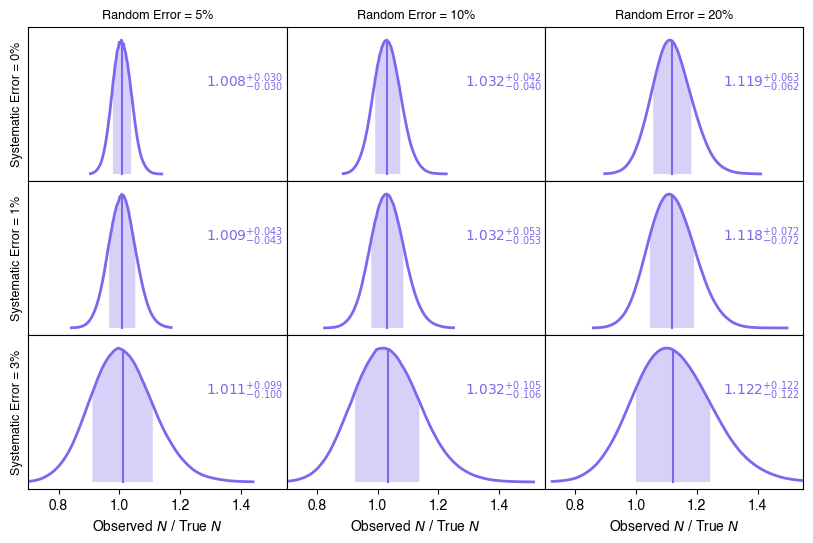

In [4]:
n_steps = 10000
d_randoms = [1.05, 1.1, 1.2]
d_systematics = [1, 1.01, 1.03]

long_ds_list = synth_fixed_N(
    N=10000, dmin=d_min / 1.3, cumulative_pf=npf_new,
    n_steps=n_steps
)[0]

fig = plt.figure(figsize=(10, 6))

for i in range(0, 9):
    time0()
    ax = fig.add_subplot(3, 3, i + 1)
    d_random = d_randoms[i % 3]
    d_systematic = d_systematics[i // 3]
    systematic_vector = sample_factor_pdf(1, d_systematic, n_steps)
    error_ds = [
        sample_factor_pdf(1, d_random, ds.size) * ds * systematic
        for ds, systematic in zip(long_ds_list, systematic_vector)
    ]
    sample_Ns = [
        e_ds[e_ds > dmin].size / ds[ds > dmin].size 
        for ds, e_ds in zip(long_ds_list, error_ds)
    ]
    # Ns, counts = np.unique(sample_Ns, return_counts=True)
    forward_pmf = ash_pdf(sample_Ns, 10)
    forward_pmf.plot(
        label='Observed N', show_label=True, 
        rounding_n=3, dn=0, label_y=0.6, label_x=1.54,
        force_label_side='right'
    )
    plt.yticks([])
    # plt.plot(
    #     [raw_N, raw_N], [0, 1], 
    #     label='True N = ' + str(raw_N), color='orange'
    # )
    plt.xlim([0.7, 1.55])
    plt.ylim([-0.05, 1.1])
    # if i == 0:
    #     plt.legend(fontsize=8, loc='upper right')
    plt.xlabel(
        rf'Observed $N$ / True $N$'
    )
    if i < 3:
        percent = str(round(100 * (d_random - 1)))
        ax.set_title('Random Error = ' + percent + '%', size=9)
    if i % 3 == 0:
        percent = str(int(100 * (d_systematic - 1)))
        plt.ylabel('Systematic Error = ' + percent + '%', size=9)
    runtime('Runtime')
fig.subplots_adjust(wspace=0, hspace=0)
base_file = 'figs/random_forward_diameter_synthetics.'
file_name = base_file + str(n_steps) + '.pdf'
plt.gcf().savefig(file_name, bbox_inches='tight')

Runtime: 0.01655 seconds
Runtime: 0.0192 seconds
Runtime: 0.02008 seconds


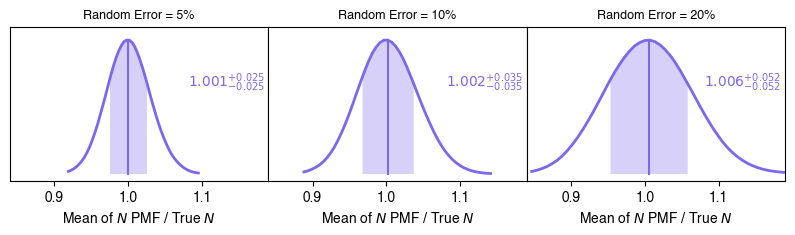

In [5]:
n_steps = 2000
d_randoms = [1.05, 1.1, 1.2]
do_calculation = False

long_ds_list = synth_fixed_N(
    N=10000, dmin=d_min / 1.3, cumulative_pf=npf_new,
    n_steps=n_steps
)[0]

fig = plt.figure(figsize=(10, 2))

for i in range(len(d_randoms)):
    time0()
    ax = fig.add_subplot(1, 3, i + 1)
    d_random = d_randoms[i]
    
    if do_calculation:
        error_ds = [
            sample_factor_pdf(1, d_random, ds_i.size) * ds_i
            for ds_i in long_ds_list
        ]
        error_ds = [eds[eds > d_min] for eds in error_ds]
        N_rvs = [N_pmf_fast(
            eds, area, dmin, d_random=d_random, n_stds=4,
            n_points=50000
        ) for eds in error_ds]
        mean_ratios = [
            N_rv.mean() / ds[ds > dmin].size 
            for N_rv, ds in zip(N_rvs, long_ds_list)
        ]

        try:
            regex = 'mean_ratios_' + str(d_random) + '_.*.txt'
            files = [
                f for f in os.listdir('saved/') if re.match(regex, f)
            ]
            file_n_steps = max([
                int(f.split('.txt')[0].split('_')[-1]) for f in files
            ])
            loadfile = (
                'saved/mean_ratios_' + str(d_random) + '_'
                '' + str(file_n_steps) + '.txt'
            )
            saved_mean_ratios = np.loadtxt(loadfile)
        except:
            saved_mean_ratios = []
            file_n_steps = 0
            
        mean_ratios = list(saved_mean_ratios) + list(mean_ratios)
        savefile = (
            'saved/mean_ratios_' + str(d_random) + '_'
            '' + str(file_n_steps + n_steps) + '.txt'
        )
        np.savetxt(savefile, mean_ratios)

    else:
        regex = 'mean_ratios_' + str(d_random) + '_.*.txt'
        files = [
            f for f in os.listdir('saved/') if re.match(regex, f)
        ]
        file_n_steps = max([
            int(f.split('.txt')[0].split('_')[-1]) for f in files
        ])
        loadfile = (
            'saved/mean_ratios_' + str(d_random) + '_'
            '' + str(file_n_steps) + '.txt'
        )
        mean_ratios = np.loadtxt(loadfile)

    reverse_pdf = ash_pdf(mean_ratios, 5)
    reverse_pdf.plot(
        label=True, 
        rounding_n=3, dn=0, label_y=0.6, label_x=1.185,
        force_label_side='right'
    )
    plt.yticks([])
    plt.xlim([0.84, 1.19])
    plt.ylim([-0.05, 1.1])
    plt.xlabel(
        rf'Mean of $N$ PMF / True $N$'
    )
    if i < 3:
        percent = str(round(100 * (d_random - 1)))
        ax.set_title('Random Error = ' + percent + '%', size=9)
    runtime('Runtime')
fig.subplots_adjust(wspace=0, hspace=0)
base_file = 'figs/random_reverse_diameter_synthetics.'
file_name = base_file + str(len(mean_ratios)) + '.pdf'
plt.gcf().savefig(file_name, bbox_inches='tight')

Runtime: 0.01856 seconds
Runtime: 0.02061 seconds
Runtime: 0.02257 seconds


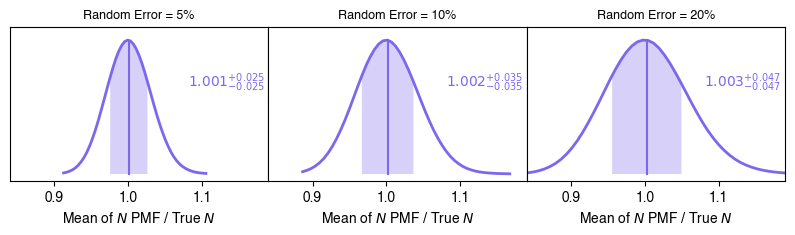

In [6]:
n_steps = 10000
d_randoms = [1.05, 1.1, 1.2]
do_calculation = False

long_ds_list = synth_fixed_N(
    N=10000, dmin=d_min / 1.3, cumulative_pf=npf_new,
    n_steps=n_steps
)[0]

X = np.logspace(-2.5, 3, 50000)
npf_rv = RandomVariable(X, npf_new_dif(X))

fig = plt.figure(figsize=(10, 2))

for i in range(0, 3):
    time0()
    ax = fig.add_subplot(1, 3, i + 1)
    d_random = d_randoms[i]
    
    if do_calculation:
        error_ds = [
            sample_factor_pdf(1, d_random, ds_i.size) * ds_i
            for ds_i in long_ds_list
        ]
        error_ds = [eds[eds > d_min] for eds in error_ds]
        N_rvs = [N_pmf_fast(
            eds, area, dmin, d_random=d_random, n_stds=5,
            n_points=50000, sfd_rv=npf_rv
        ) for eds in error_ds]
        mean_ratios = [
            N_rv.mean() / ds[ds > dmin].size 
            for N_rv, ds in zip(N_rvs, long_ds_list)
        ]

        try:
            regex = 'mean_ratios_npf_' + str(d_random) + '_.*.txt'
            files = [
                f for f in os.listdir('saved/') if re.match(regex, f)
            ]
            file_n_steps = max([
                int(f.split('.txt')[0].split('_')[-1]) for f in files
            ])
            loadfile = (
                'saved/mean_ratios_npf_' + str(d_random) + '_'
                '' + str(file_n_steps) + '.txt'
            )
            saved_mean_ratios = np.loadtxt(loadfile)
        except:
            saved_mean_ratios = []
            file_n_steps = 0
            
        mean_ratios = list(saved_mean_ratios) + list(mean_ratios)
        savefile = (
            'saved/mean_ratios_npf_' + str(d_random) + '_'
            '' + str(file_n_steps + n_steps) + '.txt'
        )
        np.savetxt(savefile, mean_ratios)

    else:
        regex = 'mean_ratios_npf_' + str(d_random) + '_.*.txt'
        files = [
            f for f in os.listdir('saved/') if re.match(regex, f)
        ]
        file_n_steps = max([
            int(f.split('.txt')[0].split('_')[-1]) for f in files
        ])
        loadfile = (
            'saved/mean_ratios_npf_' + str(d_random) + '_'
            '' + str(file_n_steps) + '.txt'
        )
        mean_ratios = np.loadtxt(loadfile)

    reverse_pdf = ash_pdf(mean_ratios, 5)
    reverse_pdf.plot(
        label=True, 
        rounding_n=3, dn=0, label_y=0.6, label_x=1.185,
        force_label_side='right'
    )
    plt.yticks([])
    plt.xlim([0.84, 1.19])
    plt.ylim([-0.05, 1.1])
    plt.xlabel(
        rf'Mean of $N$ PMF / True $N$'
    )
    if i < 3:
        percent = str(round(100 * (d_random - 1)))
        ax.set_title('Random Error = ' + percent + '%', size=9)
    runtime('Runtime')
fig.subplots_adjust(wspace=0, hspace=0)
base_file = 'figs/random_reverse_diameter_synthetics_npf.'
file_name = base_file + str(n_steps) + '.pdf'
plt.gcf().savefig(file_name, bbox_inches='tight')